### This is a notebook that illustrates some of the concepts from the Mihalas Section 14: Radiative Transfer in Moving Atmospheres 


#### First we are convincing ourselves about some basic stuff, using observer's frame, and casting radiative transfer equation in terms of reduced frequency x, direction and optical depth. 

In [30]:
import numpy as np 
import matplotlib.pyplot as plt 

In [49]:
def solve_RTE(tau, S):

    ND = len(tau)
    I = np.zeros(ND)  # initialize the intensity
    # Lower boundary condition: 
    I[-1] = S[-1]  # intensity at the bottom of the atmosphere is equal to the source function at the bottom of the atmosphere

    for d in range(ND-2, -1, -1):

        deltatau = tau[d+1] - tau[d]
        if (deltatau < 0):
            deltatau = 0.0  # to avoid negative optical depths
        
        if (deltatau < 1e-3):
            # Use Taylor expansion for small optical depths
            S_mean = 0.5 * (S[d+1] + S[d])
            I[d] = I[d+1] * (1 - deltatau) + S_mean * deltatau
            continue
        else:
            S_mean = 0.5 * (S[d+1] + S[d])
            I[d] = I[d+1] * np.exp(-deltatau) + S_mean * (1 - np.exp(-deltatau))

    return I

In [63]:
# Define grid of reduced wavelengths: 
NL = 141
x = np.linspace(-7,7,NL)

ND = 101
# Define spatial grid in tau
# Now this tau has different meaning compared to the previous one. Now tau is tau in the continuum, so we will call it like that 
logtauc = np.linspace(-5,1,ND)
tauc = 10**logtauc

# Define source function, consider it given we are not talking about non-LTE here!
# For example we take linear source function with log tau
S = 0.2 + (logtauc+5)/5

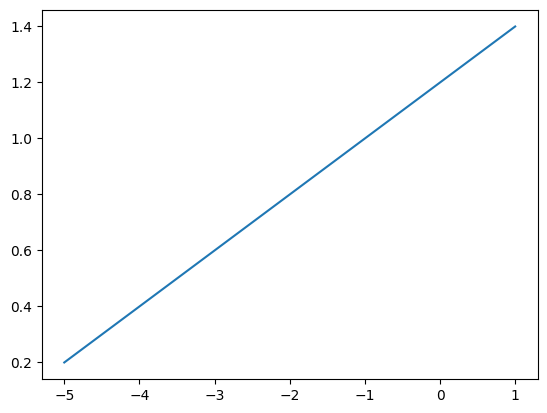

In [64]:
# Test plot the source function:
plt.plot(logtauc,S)

In [65]:
# Let's now see what happens when we have doppler shifts due to velocity fields.

def calc_phi(x, mu, V):
    # V is in units of doppler width
    xprim = x - mu*V
    return (1/np.sqrt(np.pi)) * np.exp(-xprim**2)

In [44]:
def convert_x_to_lambda(x, lambda0, delta_lambda_D):
    lambda_vals = lambda0 - x * delta_lambda_D
    return lambda_vals

#### So far so good - now let's see what happens when we have a velocity gradient!

In [66]:
# Good to have a function that solves the whole spectrum synthesis for given V and mu: 
def synthesize_spectrum(S, tau, V, mu, eta): 
    # New quantity here is eta - which we call the line strength parameter!
    spectrum = np.zeros(NL)
    for l in range(NL):
        phi = calc_phi(x[l], mu, V)
        tau_x = tau * (eta * phi + 1)  # total optical depth at wavelength x
        I = solve_RTE(tau_x, S)
        spectrum[l] = I[0]  # emergent intensity at the top of the atmosphere   
    return spectrum

def synthesize_full_intensity(S, tau, V, mu, eta):
    ND = len(S)
    full_intensity = np.zeros([ND,NL])
    for l in range(NL):
        phi = calc_phi(x[l], mu, V)
        tau_x = tau * (eta * phi + 1)
        I = solve_RTE(tau_x, S)
        full_intensity[:, l] = I  # store the full intensity profile for each wavelength
    return full_intensity

In [74]:
V = np.zeros(ND)
spectrum = synthesize_spectrum(S, tauc, V, 1.0, eta=10000.0)

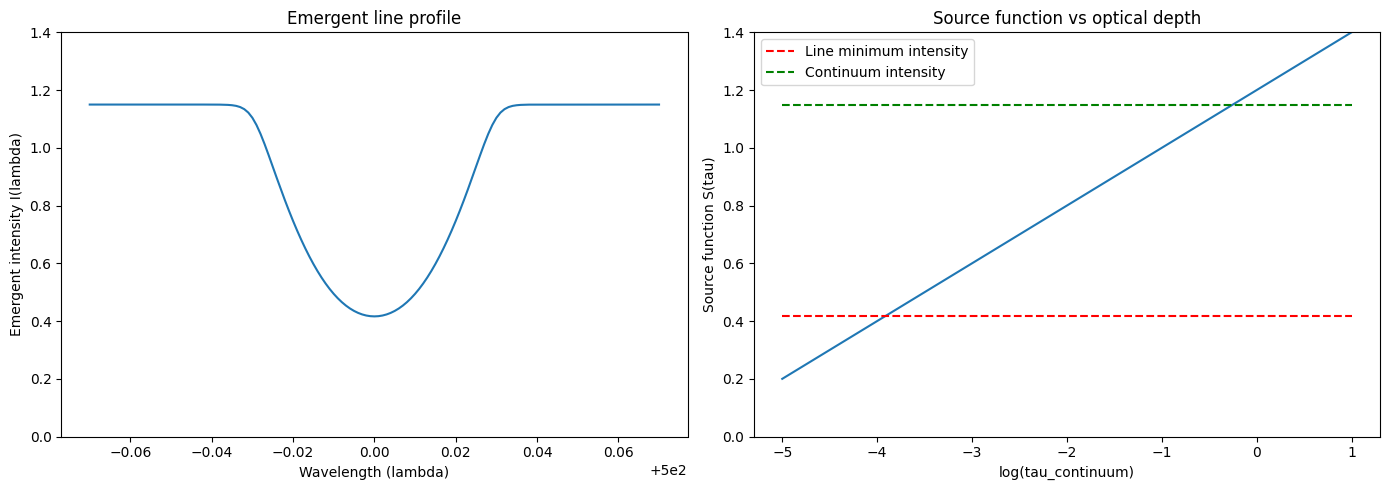

In [75]:
# Make a plot to test: 
lambda_vals = convert_x_to_lambda(x, 500.0, 0.01)  # example values
plt.figure(figsize=[14,5])
plt.subplot(121)
plt.plot(lambda_vals, spectrum)
plt.xlabel("Wavelength (lambda)")
plt.ylabel("Emergent intensity I(lambda)")
plt.title("Emergent line profile")
plt.ylim(0,1.4)
plt.subplot(122)
plt.plot(logtauc, S)
plt.ylim(0,1.4)
plt.xlabel("log(tau_continuum)")
plt.ylabel("Source function S(tau)")
plt.title("Source function vs optical depth")
plt.hlines(y=spectrum.min(), xmin=-5, xmax=1, color='r', linestyle='--', label='Line minimum intensity')
plt.hlines(y=spectrum.max(), xmin=-5, xmax=1, color='g', linestyle='--', label='Continuum intensity')
plt.legend()
plt.tight_layout()

In [86]:
# Now let's plug in some depth dependennt velocity field, and try to guess how the bisector will look like.
V = np.linspace(0,2,ND)  # velocity increasing with depth
spectrum = synthesize_spectrum(S, tauc, V, 1.0, eta=10000.0)

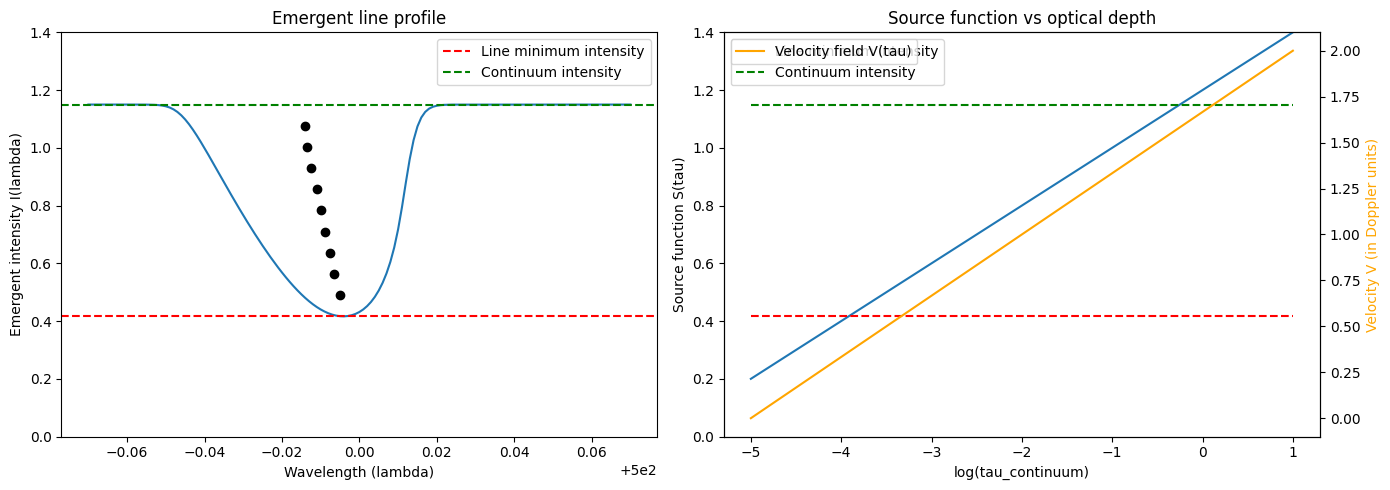

In [87]:
# Make a plot to test: 
lambda_vals = convert_x_to_lambda(x, 500.0, 0.01)  # example values
plt.figure(figsize=[14,5])
plt.subplot(121)
plt.plot(lambda_vals, spectrum)
plt.xlabel("Wavelength (lambda)")
plt.ylabel("Emergent intensity I(lambda)")
plt.title("Emergent line profile")
plt.ylim(0,1.4)
# Overplot the bisector here:
plt.axhline(y=spectrum.min(), color='r', linestyle='--', label='Line minimum intensity')
plt.axhline(y=spectrum.max(), color='g', linestyle='--', label='Continuum intensity')
for i in range(1,10):
    level = spectrum.min() + i * (spectrum.max() - spectrum.min()) / 10
    indices = np.where(spectrum <= level)[0]
    if len(indices) > 0:
        left_index = indices[0]
        right_index = indices[-1]
        bisector_wavelength = 0.5 * (lambda_vals[left_index] + lambda_vals[right_index])
        plt.plot(bisector_wavelength, level, 'ko')  # plot bisector point
plt.legend()

plt.subplot(122)
plt.plot(logtauc, S)
plt.ylim(0,1.4)
plt.xlabel("log(tau_continuum)")
plt.ylabel("Source function S(tau)")
plt.title("Source function vs optical depth")
plt.hlines(y=spectrum.min(), xmin=-5, xmax=1, color='r', linestyle='--', label='Line minimum intensity')
plt.hlines(y=spectrum.max(), xmin=-5, xmax=1, color='g', linestyle='--', label='Continuum intensity')
plt.legend()
# Add another line showing the velocity field
plt.twinx()
plt.plot(logtauc, V, color='orange', label='Velocity field V(tau)')
plt.ylabel("Velocity V (in Doppler units)", color='orange')
plt.legend(loc='upper left')
plt.tight_layout()

In [90]:
# Similar example, except we now have a velocity discontinuity at a given optical depth, for example log tau = -2.0
V = np.zeros(ND)
discontinuity_index = np.argmin(np.abs(logtauc - (-2.0)))
V[:discontinuity_index] = 2.0  # velocity jumps to 2.0 at log tau = -2.0
spectrum = synthesize_spectrum(S, tauc, V, 1.0, eta=10000.0)

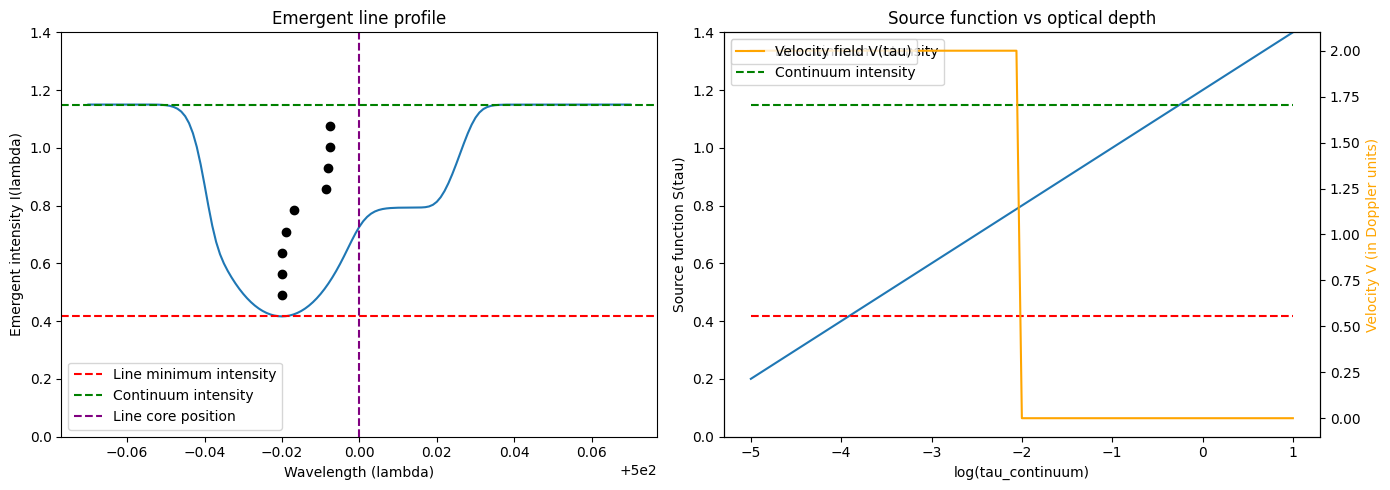

In [91]:
# Make a plot to test: 
lambda_vals = convert_x_to_lambda(x, 500.0, 0.01)  # example values
plt.figure(figsize=[14,5])
plt.subplot(121)
plt.plot(lambda_vals, spectrum)
plt.xlabel("Wavelength (lambda)")
plt.ylabel("Emergent intensity I(lambda)")
plt.title("Emergent line profile")
plt.ylim(0,1.4)
# Overplot the bisector here:
plt.axhline(y=spectrum.min(), color='r', linestyle='--', label='Line minimum intensity')
plt.axhline(y=spectrum.max(), color='g', linestyle='--', label='Continuum intensity')
for i in range(1,10):
    level = spectrum.min() + i * (spectrum.max() - spectrum.min()) / 10
    indices = np.where(spectrum <= level)[0]
    if len(indices) > 0:
        left_index = indices[0]
        right_index = indices[-1]
        bisector_wavelength = 0.5 * (lambda_vals[left_index] + lambda_vals[right_index])
        plt.plot(bisector_wavelength, level, 'ko')  # plot bisector point
# Finally a vline showing the line core position
plt.vlines(x=lambda_vals[NL//2], ymin=0, ymax=1.4, color='purple', linestyle='--', label='Line core position')
plt.legend()

plt.subplot(122)
plt.plot(logtauc, S)
plt.ylim(0,1.4)
plt.xlabel("log(tau_continuum)")
plt.ylabel("Source function S(tau)")
plt.title("Source function vs optical depth")
plt.hlines(y=spectrum.min(), xmin=-5, xmax=1, color='r', linestyle='--', label='Line minimum intensity')
plt.hlines(y=spectrum.max(), xmin=-5, xmax=1, color='g', linestyle='--', label='Continuum intensity')
plt.legend()
# Add another line showing the velocity field
plt.twinx()
plt.plot(logtauc, V, color='orange', label='Velocity field V(tau)')
plt.ylabel("Velocity V (in Doppler units)", color='orange')
plt.legend(loc='upper left')
plt.tight_layout()

In [92]:
# To understand what is going on here, use the full intensity profiles:
full_intensity = synthesize_full_intensity(S, tauc, V, 1.0, eta=10000.0)

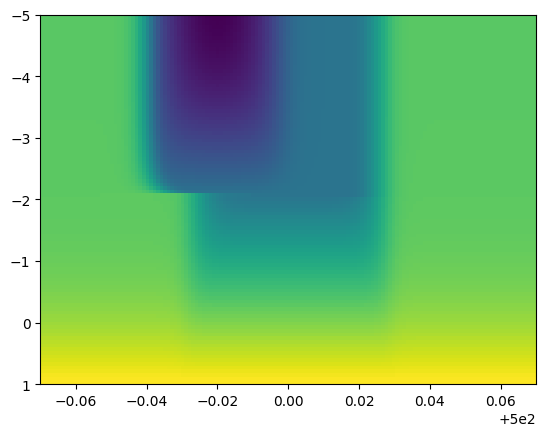

In [98]:
plt.imshow(full_intensity[:,::-1], extent=[lambda_vals[-1], lambda_vals[0], logtauc[-1], logtauc[0]], aspect='auto')

In [ ]:
# This discussion above clarifies the very compact paragraph on page 455, which was not super obvious at the time when we read it.